![out-liar](https://i2.wp.com/oklahomaanalytics.com/wp-content/uploads/2016/12/outlier-pic-1.jpg?w=589)

## Uncertainty estimates from curvefit and scipy.optimize.minimize



We previously examined how to estimate uncertainty from the covariance matrix returned from curve_fit. Recall we need the diagonal of the covariance matrix, which is estimated during the fitting.  The covariance matrix is related to the inverse Hessian matrix. We will explore how these are related here.

We will consider fitting a line to the following data.

In [13]:
from scipy.optimize import least_squares
?least_squares

In [11]:
?curve_fit

In [16]:
import numpy as np
from scipy.optimize import curve_fit

x = np.array([0.0, 2.5, 5.0, 7.5, 10.0])
y = np.array([1.14, 1.91, 2.48, 2.2, 4.0])


def model(x, m, b):
    return m * x + b


p, pcov = curve_fit(model, x, y, [0.2, 0.1], ftol=1e-9, xtol=1e-9, gtol=1e-9)
print(p)
with np.printoptions(precision=3):
    print(pcov)

[0.2404     1.14399999]
[[ 0.004 -0.022]
 [-0.022  0.162]]


`scipy.optimize.minimize` does not return the covariance matrix; with *some* of the methods, it returns an estimate of the inverse Hessian matrix. In theory, the covariance matrix and the inverse hessian are related to each other with $cov = 0.5 * H^{-1}$. Note this relationship is specific to the minimization of the summed squared errors.



In [6]:
from scipy.optimize import minimize


def model(pars, _x):
    _x = np.array(_x)
    m, b = pars
    return m * _x + b


def objective(pars):
    errs = y - model(pars, x)
    return np.sum(errs**2)


sol = minimize(objective, [0.2, 1])
print(sol.x)

with np.printoptions(precision=3):
    print(0.5 * sol.hess_inv)

[0.2404     1.14399998]
[[ 0.01  -0.066]
 [-0.066  0.491]]


That doesn't look very good. **But**, remember that it is an *estimate* of the Hessian and we need to be careful about the accuracy. The minimizer terminates when the solution reaches the tolerance, *not* when the Hessian is accurate! If we make the tolerance smaller, we get a more accurate result.



In [7]:
?minimize

In [10]:
sol = minimize(objective, [0.2, 1], tol=1e-12)
print(sol.x)
with np.printoptions(precision=3):
    print(0.5 * sol.hess_inv)

[0.24039999 1.144     ]
[[ 0.004 -0.023]
 [-0.023  0.171]]


In [ ]:
??curve_fit

With the increased accuracy, you can see the covariance is approximately equal to 1/2 the inverse Hessian. That means you can use it to estimate the uncertainty in the same way we did with curve\_fit.

Not all solvers generate the inverse Hessian matrix, e.g. `SLSQP` does not do it. You have three options. One is always to compute the Hessian analytically. The other two options rely on libraries that use automatic differentiation to compute the relevant derivatives. One is to use numdifftools (which you may have to install). Either way, you have to compute the Hessian on the objective function that is being minimized. One way to get this is to use a numerical package designed to compute this. We can use [numdifftools](https://numdifftools.readthedocs.io/en/latest/) for this.

Now, similar to what we did with `scipy.misc.derivative`, we can write a function and then use numdifftools to get the Hessian of the function. Here, we define the sum of the squared errors function, then create a Hessian function for that. We can use the Hessian function to evaluate the Hessian at the parameters at the minimum. We use `numpy.linalg.inv` to get the inverse of the Hessian to compute the covariance.



In [1]:
import numdifftools as nd


def f(pars):
    m, b = pars
    return np.sum((y - (m * x + b)) ** 2)


H = nd.Hessian(f)  # H is an executable function now that takes one argument, the pars.
0.5 * np.linalg.inv(H(p))

NameError: name 'np' is not defined

In [27]:
# Work out the analytical solution here.
# 2 * (y - (mx + b)) * -x  #J(m)
# -2x * y + 2x*(mx +b)
# 2m x2
m, b = sol.x
print(np.sum(2 * (y - (m * x + b)) * -x))
print(np.sum(2 * x**2))
H(sol.x)

-2.3704986791273086e-06
375.0


array([[375.,  50.],
       [ 50.,  10.]])

`numdifftools` ([https://pypi.org/project/numdifftools/](https://pypi.org/project/numdifftools/)) is a numerical differentiation package. It is more sophisticated than `scipy.misc.derivative` but is fundamentally still a numerical approximation to the derivatives. Now you can use these to estimate the uncertainties even for optimizers that don't provide the estimated inverse Hessian.

Later we will learn about one more approach to getting the derivatives that is used in machine learning called automatic differentiation.



## Effects of outliers on regression



Outliers can have a significant effect on the fit of a model to data. Let's consider this example, where we want to fit a line to some data that has an outlier in it. This is just a linear regression, and we start out using `numpy.polyfit`.



[0.2404 1.144 ]


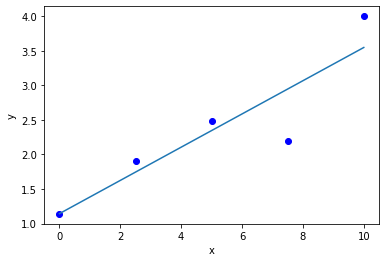

In [32]:
import numpy as np
import matplotlib.pyplot as plt

x = [0.0, 2.5, 5.0, 7.5, 10.0]
y = [1.14, 1.91, 2.48, 2.2, 4.0]
#                            ^
#                            |
#                         outlier

p = np.polyfit(x, y, 1)
print(p)
xfit = np.linspace(0, 10)

plt.plot(x, y, "bo")
plt.plot(xfit, np.polyval(p, xfit))
plt.xlabel("x")
plt.ylabel("y");

You can see that the fitted line is "dragged" towards the outlier. We say that least squares minimization is not *robust* to outliers.

This may be undesirable because if you believe there is an outlier, perhaps due to experimental error, then this point affects the accuracy of the model more than the other points you believe to be more accurate.

Today we will consider a variety of approaches to minimize the effects of outliers. We first begin by re-examining how these parameters are obtained. Here, we illustrate that the results from polyfit are equivalent to minimizing the summed squared errors between the model and the data.

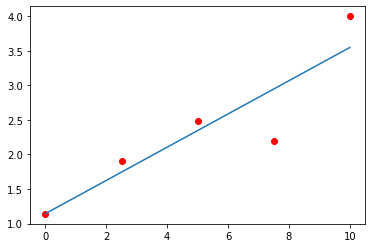

In [34]:
from scipy.optimize import minimize


def model(pars, x):
    x = np.array(x)  # this just makes sure that x is an array
    m, b = pars
    return m * x + b


def objective(pars):
    errs = y - model(pars, x)
    return np.sum(errs**2)


sol = minimize(objective, [0.2, 1])

plt.plot(x, y, "ro")
X = np.linspace(min(x), max(x))
plt.plot(X, model(sol.x, X));

The problem is that we are minimizing the error<sup>2</sup>, which puts more weight on large errors than small errors.

Least squares regression is also called L<sub>2</sub> norm regression, that is we minimize the L<sub>2</sub> norm of the error vector.



Sum of error squared = dot(err, err) = err @ err

### Minimizing the summed absolute errors



We can choose to minimize another objective function, for example the summed absolute value of the errors. This will reduce the emphasis on large errors. This is  also called L<sub>1</sub> norm regression.



[0.26845682 1.14      ]
1.230000002431845


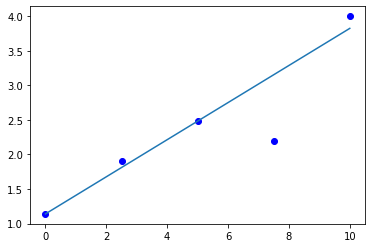

In [38]:
def objective(pars):
    errs = y - model(pars, x)
    return np.sum(np.abs(errs))


L1_sol = minimize(objective, [0.2, 1])
print(L1_sol.x)
plt.plot(x, y, "bo")
plt.plot(xfit, model(L1_sol.x, xfit))
print(objective(L1_sol.x))

There is a historical reason this is not done a lot, and that is the absolute value function has a discontinuity in its first derivative at the origin which can be problematic in some optimization algorithms. It is obviously not a problem here, and you can see that the outlier has less of an effect on the fitted line in this case.

Finally, we can generalize these ideas to something called L<sub>p</sub> norm regressions where we seek to minimize:

$\sum |\epsilon_i|^p$

In [this paper](https://www.tandfonline.com/doi/abs/10.1080/00401706.1972.10488892) a value of $p=1.5$ is recommended for general use. Note this is less than two, and greater than one, so it is expected to have an intermediate effect compared to L<sub>1</sub> and L<sub>2</sub> norm regression.



[0.25741034 1.15352086]


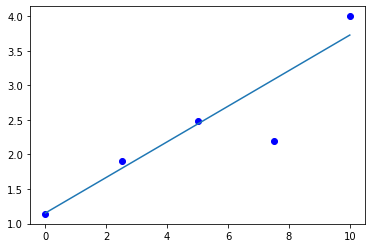

In [39]:
def objective(pars):
    p = 1.5
    errs = y - model(pars, x)
    return np.sum(np.abs(errs) ** p)


Lp_sol = minimize(objective, [0.2, 1])
print(Lp_sol.x)
plt.plot(x, y, "bo")
plt.plot(xfit, model(Lp_sol.x, xfit));

The downside of these approaches is that they complicate the analysis of uncertainty. The uncertainty analysis we have considered so far is only formally correct when we minimize the summed squared errors. It is only approximately correct when something else is minimized.



### Robust regression approaches



An alternative approach to least squares or absolute error minimization is called robust regression (see Applied Regression Analysis, 3rd edition, Draper and Smith, chapter 25). This is a class of methods that uses a different metric to minimize in the objective function.

The simplest approach is to minimize the median of the squared error. Note that minimizing the sum of squared errors is practically like minimizing the average or mean squared error. If you have a symmetric distribution of errors, then the mean and median are practically the same. If there is an outlier, however, the mean will be skewed towards the outlier, while the median will be at a position that splits the distribution in half, and is closer to what you believe the mean to be.

Here we show that given an asymmetric distribution, the median is smaller than the mean.



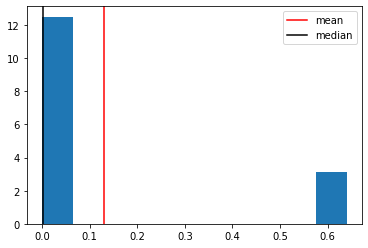

In [40]:
errs = np.array([0.1, 0.01, 0.05, 0.02, 0.8])
s = errs**2
plt.hist(s, density=True)
plt.axvline(np.mean(s), color="r")
plt.axvline(np.median(s), color="k")
plt.legend(["mean", "median"])
plt.xlabel("")
# this gets rid of the x-label

#### Least Median regression



It is straightforward to modify the objective function to minimize the median of the squared errors.



[0.28599999 1.16750001]


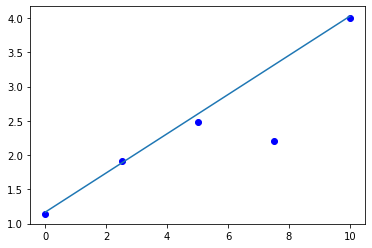

In [41]:
def objective(pars):
    errs = y - model(pars, x)
    return np.median(errs**2)


LMS_sol = minimize(objective, [-0.2, 1])
print(LMS_sol.x)
plt.plot(x, y, "bo")
plt.plot(xfit, model(LMS_sol.x, xfit));

### Weighted nonlinear regression



Outliers often are associated with larger uncertainties about their values. An alternative approach to the methods described above is to use weights to say how important each data point is. This example is adapted from [https://www.mathworks.com/help/stats/examples/weighted-nonlinear-regression.html](https://www.mathworks.com/help/stats/examples/weighted-nonlinear-regression.html).



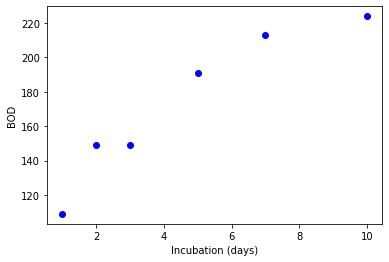

In [45]:
import numpy as np
import matplotlib.pyplot as plt

x = [1, 2, 3, 5, 7, 10]
y = [109, 149, 149, 191, 213, 224]
plt.plot(x, y, "bo")
plt.xlabel("Incubation (days)")
plt.ylabel("BOD");

The aim of this work is to fit a nonlinear model $y= a (1 - e^{-b x})$ to this data. We first consider a standard minimization of the sum squared errors. Inspection of the model suggests at large x, $a$ is a plateau value, which we can read from the graph. For the value of $b$, we might estimate a half-life at about one day and solve $110 = 240(1 - e^{-b})$



In [46]:
-np.log(-(110 / 240 - 1))

0.6131044728864088

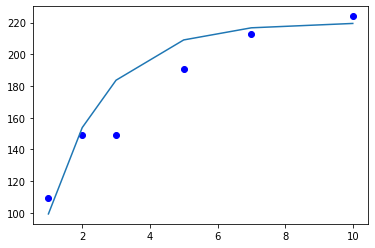

In [47]:
x = np.array(x)
plt.plot(x, y, "bo", x, 220 * (1 - np.exp(-0.6 * x)));

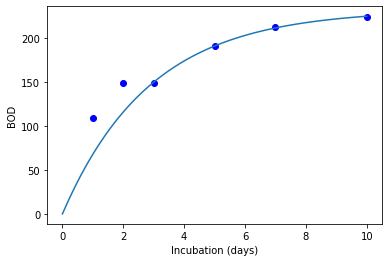

In [53]:
def model(pars, x):
    a, b = pars
    x = np.array(x)
    return a * (1 - np.exp(-b * x))


def objective(pars):
    errs = y - model(pars, x)
    return np.median(errs**2)


guesses = [240, 0.6]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x

plt.plot(x, y, "bo")
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel("Incubation (days)")
plt.ylabel("BOD");

The fit generally goes through the data, but it is not clear if there is a small outlier near 2 that is skewing the fit, and perhaps leading to an inaccurate asymptote at long times.

Suppose, however, that these data points represent averages from multiple measurements, and we only measured the first two points once, and the rest of the points 5 times. In this case, we might want to put more *weight* on the points we measured multiple times.

We achieve this by modifying the objective function, in this case multiplying each error by the number of times the measurement was made. This makes reducing errors on points we measured a lot more important than the points we measured less.



[230.77020592   0.35563067]


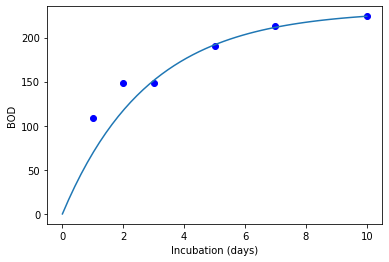

In [54]:
w = np.array([1, 1, 5, 5, 5, 5])


def objective(pars):
    errs = (y - model(pars, x)) * w  # multiply the errors by the weights
    return np.sum(errs**2)


guesses = [240, 0.5]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x
print(pars)
plt.plot(x, y, "bo")
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel("Incubation (days)")
plt.ylabel("BOD");

The result here is that the model fits the points we measured a lot better than the points we measured once.

There are many ways you could choose to weight the points depending on what you know about them. If you have uncertainties about the measured data, you can weight the points accordingly, e.g. defining the weights as inversely proportional to the uncertainty.



[230.12680918   0.3602567 ]


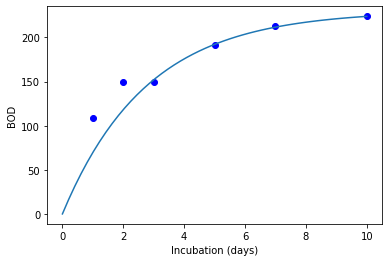

In [55]:
se = np.array(
    [12, 10, 3, 2, 4, 1]
)  # these are uncertainties/std err on each measurement
w = 1 / se  # weight is inversely proportional to the SE.


def objective(pars):
    errs = (y - model(pars, x)) * w  # multiply the errors by the weights
    return np.sum(errs**2)


guesses = [240, 0.5]

from scipy.optimize import minimize

sol = minimize(objective, guesses)
pars = sol.x
print(pars)
plt.plot(x, y, "bo")
xfit = np.linspace(0, 10)
plt.plot(xfit, model(pars, xfit))
plt.xlabel("Incubation (days)")
plt.ylabel("BOD");

you can see the errors like this.

In [56]:
errs = y - model(pars, x)
errs

array([39.38600801, 30.83043984, -3.03693557, -1.13589688,  1.3558615 ,
        0.14499123])

In [57]:
np.std(errs[2:])  # for the last 4 points

1.6269414034040128

In [58]:
np.var(errs), np.std(errs) ** 2

(292.29506781938915, 292.2950678193891)

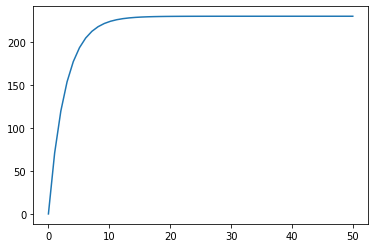

In [59]:
xfit = np.linspace(0, 50)
plt.plot(xfit, model(pars, xfit));

In [60]:
model(pars, xfit)[-1]

230.12680572339715

In [61]:
# find time to reach 90% of saturation
from scipy.optimize import fsolve


def g(x):
    return model(pars, x) - 0.9 * 230


fsolve(g, 5)

array([6.37777996])

## Summary



Regression is an important technical skill required in modern engineering. It is the method which we use to convert data into models. Sometimes it is the parameters that are important, e.g. when they represent properties of a system that we are interested in. Sometimes it is the model that is interesting, e.g. when we need to use it for optimization or predictions.

At the core, regression involves minimization of some error function. The standard method is to minimize the summed squared error between the model and data. There are some benefits to this method: it is straight forward and there are well established methods to estimate the uncertainty in the parameters. However, it is known to be sensitive to outliers.

A variety of alternative approaches exist to reduce the influence of outliers, including minimizing the summed absolute errors, robust regression methods, and weighted regression methods. It is not always obvious what the right method to use is, this takes experience and an understanding of what you know about the model, the data, and the goals of the regression.



In [65]:
?minimize